In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Task 1: Implement the Metropolis Hastings algorithm

Implement a Metropolis Hastings algorithm where you use a multivariate normal distribution for the proposal distribution.

Remember that the algorithm is as follows:

0. Choose an initial point $x_0$.
1. Propose a new point $x^\prime$ based on the current point $x_t$ and a proposal distribution $q(x^\prime \mid x_t)$.
2. Calculate the acceptance probability:
   $$A(x^\prime, x_t) = \min\left(1, \frac{p(x^\prime)}{p(x_t)}\right)$$
3. Generate a sample $u$ from $U(0, 1)$.
   - If $u \leq A(x^\prime, x_t)$: accept the new state. → $x_{t+1} = x^\prime$.
   - If $u \gt A(x^\prime, x_t)$: reject the new state. → $x_{t+1} = x_t$.
  
You can use the function templates below to get started.

In [28]:
def sample_metropolis_hastings(
    start_value,
    compute_target_pdf,
    compute_proposal_pdf,
    draw_proposal_sample,
    num_samples,
    proposal_cov=1.0,
):
    """Generate samples from a target distribution with the Metropolis Hastings algorithm
    
    start value: np.array
      The starting point of the parameter vector
    compute_target_pdf: callable
      Function to compute the pdf of the target distribution (up to a constant)
    compute_proposal_pdf: callable
      Function to compute the pdf of the proposal distribution
    num_samples: integer
      Number of samples to generate
    proposal_cov: np.array
      Covariance matrix of the proposal distribution
    """
    # Write your code here
    samples = np.zeros((num_samples, len(start_value)))
    current = start_value
    for i in range(num_samples):
        # Draw a proposal sample
        proposal = draw_proposal_sample(current, proposal_cov)
        # Compute the acceptance probability
        acceptance = min(1, ((compute_target_pdf(proposal) * compute_proposal_pdf(current, proposal)) /
                         (compute_target_pdf(current) * compute_proposal_pdf(proposal, current))))
        # Accept or reject the proposal
        if np.random.rand() < acceptance:
            current = proposal
        samples[i] = current

    return samples

def draw_proposal_sample(x, proposal_cov):
    "Draw a sample from a Normal proposal distribution centered at `x` with covariance `proposal_cov`"
    return np.random.multivariate_normal(x, proposal_cov)

def compute_proposal_logpdf(x, y, proposal_cov):
    "Evaluate the PDF of the proposal density with mean x and covariance proposal_cov at location y"
    return stats.multivariate_normal.logpdf(y, mean=x, cov=proposal_cov)

# Task 2: Sample from a Multivariate Normal distribution and inspect the results

Use the Metropolis-Hastings algorithm you implemented to sample from the target distribution given below.
For the proposal distribution, use a symmetric multivariate normal distribution (without off-diagonal covariance entries).
The target distribution is also a multivariate normal distribution, but it has different parameters than your proposal distribution.

- To assess convergence, make a trace plot. That is, plot the parameter values over the number of iteration. How many samples do you have to discard?
- Compute the acceptance rate of your samples. Is it too high or too low?
- Vary the parameters of your proposal distribution and observe how this affects convergence.

In [29]:
def make_target_dist():
    cov = np.array([[2, 1], [1, 7]])
    mean = np.array([100, 2])
    return stats.multivariate_normal(mean=mean, cov=cov)

C:\Users\31636\AppData\Local\Temp\ipykernel_4960\3434568821.py:29: RuntimeWarning: invalid value encountered in scalar divide
  acceptance = min(1, ((compute_target_pdf(proposal) * compute_proposal_pdf(current, proposal)) /
C:\Users\31636\AppData\Local\Temp\ipykernel_4960\3434568821.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance = min(1, ((compute_target_pdf(proposal) * compute_proposal_pdf(current, proposal)) /


Acceptance rate: 0.2660726607266073


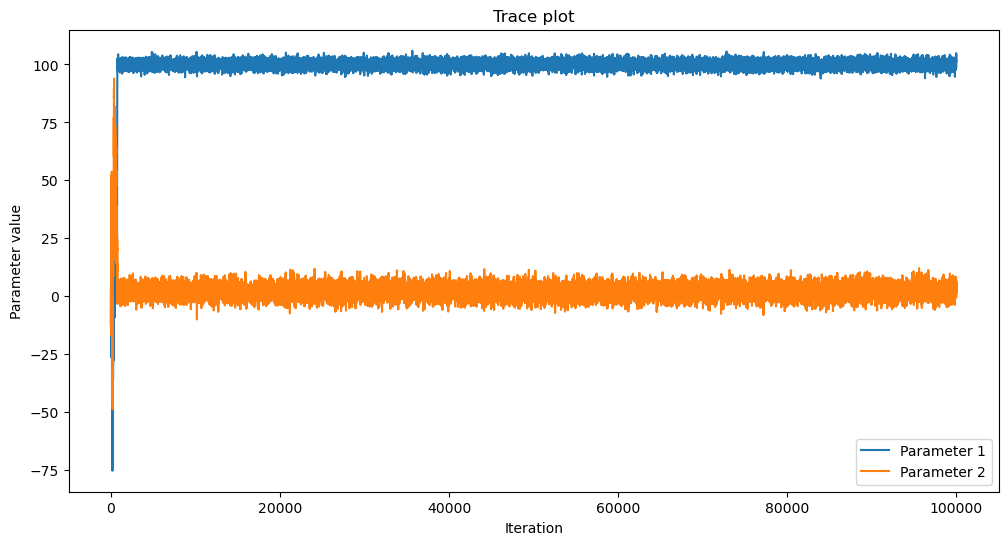

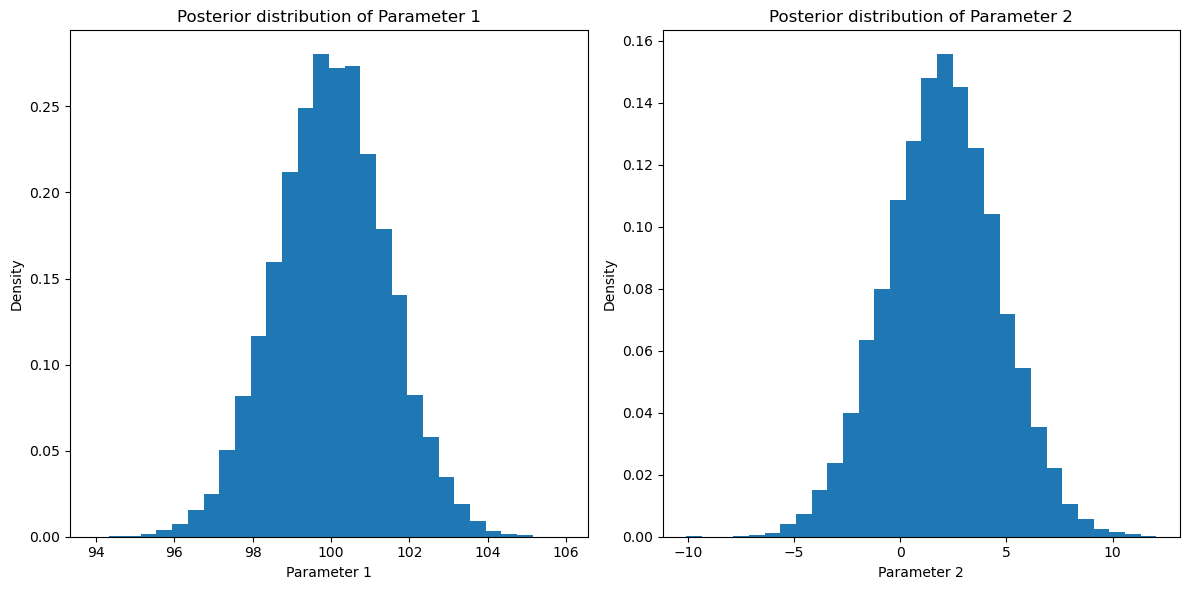

In [35]:
# Define the target distribution
target_dist = make_target_dist()

# Define the target PDF
def compute_target_pdf(x):
    return np.exp(target_dist.logpdf(x))

# Define the proposal covariance matrix (symmetric, without off-diagonal entries)
proposal_cov = np.array([[16, 0], [0, 16]])

# Number of samples to generate
num_samples = 100000

# Starting point
start_value = np.array([0, 0])

# Generate samples using the Metropolis-Hastings algorithm
samples = sample_metropolis_hastings(
    start_value,
    compute_target_pdf,
    lambda x, y: compute_proposal_logpdf(x, y, proposal_cov),
    draw_proposal_sample,
    num_samples,
    proposal_cov
)

# Compute the acceptance rate
acceptance_rate = np.mean(np.diff(samples, axis=0) != 0)
print(f"Acceptance rate: {acceptance_rate}")

# Plot the trace plot
plt.figure(figsize=(12, 6))
plt.plot(samples[:, 0], label='Parameter 1')
plt.plot(samples[:, 1], label='Parameter 2')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()
plt.title('Trace plot')
plt.show()

# Discard the first 1000 samples as burn-in
burn_in = 1000
samples = samples[burn_in:]

# Plot histograms of the posterior samples
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(samples[:, 0], bins=30, density=True)
plt.xlabel('Parameter 1')
plt.ylabel('Density')
plt.title('Posterior distribution of Parameter 1')

plt.subplot(1, 2, 2)
plt.hist(samples[:, 1], bins=30, density=True)
plt.xlabel('Parameter 2')
plt.ylabel('Density')
plt.title('Posterior distribution of Parameter 2')

plt.tight_layout()
plt.show()

# Task 3: Create a Bayesian model for a tracer test experiment

Next, you will use the MCMC algorithm you implemented to sample the posterior distribution for a simple "real-world" model.
The model describes the transport of a solute by advection and dispersion in a column experiment.
At the beginning of the experiment, the concentration is zero throughout the column.
Then, a tracer is continuously injected into the column at one end.
The concentration of the tracer was measured at the outlet of the column over time.

![](https://www.researchgate.net/profile/Jan-Sembera/publication/267991244/figure/fig1/AS:295523958444032@1447469810359/Scheme-of-laboratory-column-experiment_W640.jpg)

We make the following assumptions:

The likelihood is a Normal distribution centered around the model outputs. The standard deviation is different for each time point.
The values of the standard deviation are given in the data frame with the experimental data.

The prior distribution for the porosity is a Beta distribution with parameter $a=2$ and $b=4$.
The prior distribution for the dispersivity is a Lognormal distribution with parameters `scale=0.1` and `s=0.5` (in Scipy).

The functions below implement the deterministic model and read in the experimental data.
You can look at the plot and vary the parameters to fit the curve manually and see the effect on the concentrations (don't spend too much time on this).

**Task**: Implement a function that evaluates the posterior PDF up to a constant.

Remember that you can compute the posterior density (up to a constant) as the product of the prior and the likelihood.

In [31]:
import pandas as pd
from scipy.special import erfc


def solve_advection_dispersion_equation(t, x, discharge, porosity, dispersivity):
    "Solve the 1-D advection dispersion equation for given parameters"
    v = discharge / porosity
    D = v * dispersivity
    return 0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t)))


def read_data():
    df = pd.read_csv("concentrations_mean_sd.csv").set_index("sample")
    df["std_concentration"] = np.maximum(0.01, df["std_concentration"])
    return df

C:\Users\31636\AppData\Local\Temp\ipykernel_4960\1786079507.py:9: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t)))


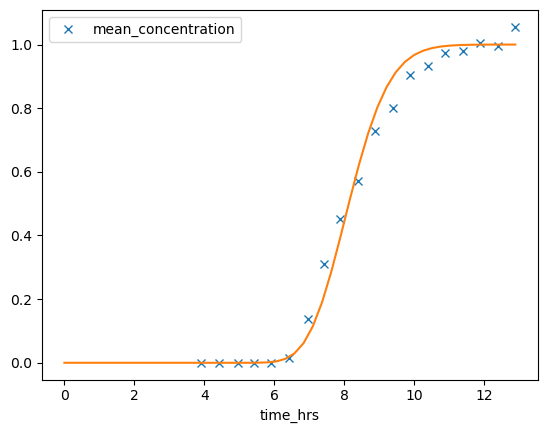

In [32]:
# Keep the next two parameters fixed
discharge = 0.007
length = 0.158

# Vary these parameters to fit the curve
porosity, dispersivity = [0.36, 0.001]

# Read in the data and run the model
df = read_data()
time = np.linspace(0, df.time_hrs.max())
simulated_concentration = solve_advection_dispersion_equation(
    time, length, discharge, porosity, dispersivity
)

# Plot the model and data
df.plot(x="time_hrs", y="mean_concentration", marker="x", lw=0)
plt.plot(time, simulated_concentration)

In [33]:
def compute_posterior_pdf(params, df, discharge, length):
    porosity, dispersivity = params
    
    # Compute the prior densities
    prior_porosity = stats.beta.pdf(porosity, a=2, b=4)
    prior_dispersivity = stats.lognorm.pdf(dispersivity, s=0.5, scale=0.1)
    
    # Compute the likelihood
    simulated_concentration = solve_advection_dispersion_equation(
        df['time_hrs'].values, length, discharge, porosity, dispersivity
    )
    likelihood = stats.norm.pdf(
        df['mean_concentration'].values, loc=simulated_concentration, scale=df['std_concentration'].values
    ).prod()
    
    # Compute the posterior density (up to a constant)
    posterior = prior_porosity * prior_dispersivity * likelihood
    
    return posterior

compute_posterior_pdf([0.36, 0.001], df, discharge, length)

1.0101451079600108e-26

In [34]:
df

,time_hrs,mean_concentration,std_concentration
sample,,,
T0,3.916667,0.000195,0.010000
T1,4.408333,0.000188,0.010000
T2,4.958333,0.000211,0.010000
T3,5.416667,0.000172,0.010000
T4,5.900000,0.000307,0.010000
T5,6.425000,0.015154,0.010000
T6,6.958333,0.136021,0.010000
T7,7.416667,0.311126,0.010443
T8,7.883333,0.450579,0.017722


# Task 4: Use MCMC to estimate the model parameters from observations

Now use the MCMC algorithm you implemented to sample the posterior distribution.

- Make a trace plot of the two parameters to assess convergence.
- You will have to tune the parameters of the proposal distribution to explore the posterior efficiently.
- Plot a histogram of the posterior samples of the two parameters.
- Plot the concentration curve for different posterior samples of the parameters.

C:\Users\31636\AppData\Local\Temp\ipykernel_4960\1786079507.py:9: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t)))
C:\Users\31636\AppData\Local\Temp\ipykernel_4960\3434568821.py:29: RuntimeWarning: invalid value encountered in scalar divide
  acceptance = min(1, ((compute_target_pdf(proposal) * compute_proposal_pdf(current, proposal)) /
C:\Users\31636\AppData\Local\Temp\ipykernel_4960\3434568821.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance = min(1, ((compute_target_pdf(proposal) * compute_proposal_pdf(current, proposal)) /


Acceptance rate: 0.9991499574978749


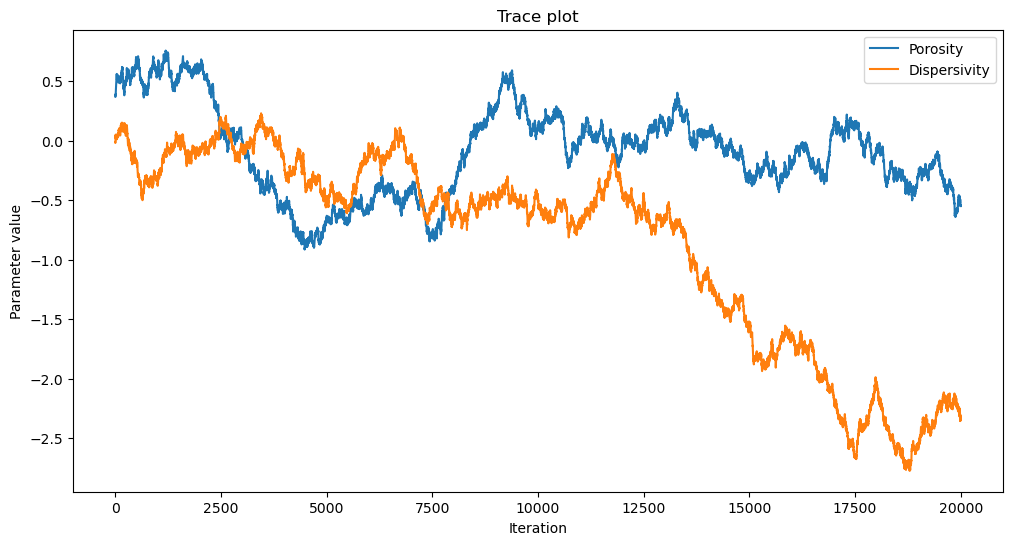

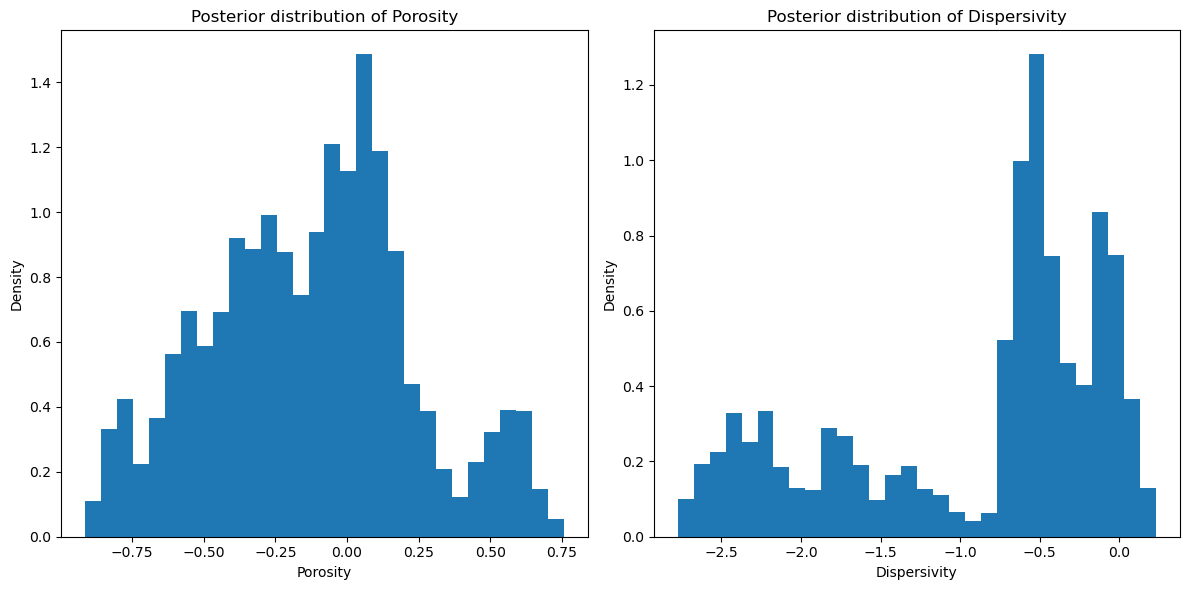

C:\Users\31636\AppData\Local\Temp\ipykernel_4960\1786079507.py:9: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t)))
C:\Users\31636\AppData\Local\Temp\ipykernel_4960\1786079507.py:9: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t)))


<Figure size 1200x600 with 0 Axes>

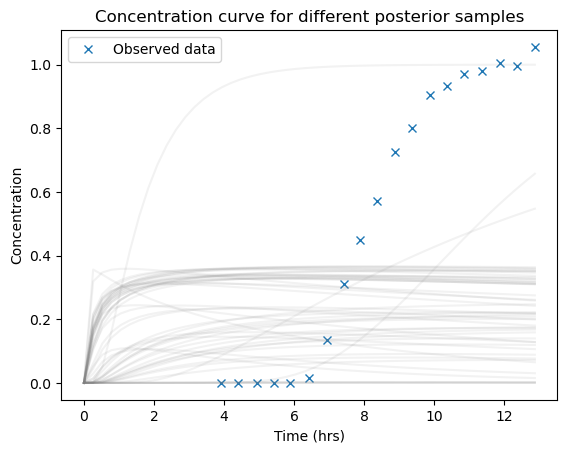

In [49]:
# Define the target PDF for the posterior distribution
def compute_target_posterior(params):
    return compute_posterior_pdf(params, df, discharge, length)

# Define the proposal covariance matrix (symmetric, without off-diagonal entries)
proposal_cov = np.array([[0.0001, 0], [0, 0.0001]])

# Number of samples to generate
num_samples = 20000

# Starting point
start_value = np.array([0.36, 0.001])

# Generate samples using the Metropolis-Hastings algorithm
posterior_samples = sample_metropolis_hastings(
    start_value,
    compute_target_posterior,
    lambda x, y: compute_proposal_logpdf(x, y, proposal_cov),
    draw_proposal_sample,
    num_samples,
    proposal_cov
)


# Compute the acceptance rate
acceptance_rate = np.mean(np.diff(posterior_samples, axis=0) != 0)
print(f"Acceptance rate: {acceptance_rate}")


# Plot the trace plot
plt.figure(figsize=(12, 6))
plt.plot(posterior_samples[:, 0], label='Porosity')
plt.plot(posterior_samples[:, 1], label='Dispersivity')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()
plt.title('Trace plot')
plt.show()

# Discard the first 1000 samples as burn-in
burn_in = 1000
posterior_samples = posterior_samples[burn_in:]

# Plot histograms of the posterior samples
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(posterior_samples[:, 0], bins=30, density=True)
plt.xlabel('Porosity')
plt.ylabel('Density')
plt.title('Posterior distribution of Porosity')

plt.subplot(1, 2, 2)
plt.hist(posterior_samples[:, 1], bins=30, density=True)
plt.xlabel('Dispersivity')
plt.ylabel('Density')
plt.title('Posterior distribution of Dispersivity')

plt.tight_layout()
plt.show()

# Plot the concentration curve for different posterior samples of the parameters
plt.figure(figsize=(12, 6))
df.plot(x="time_hrs", y="mean_concentration", marker="x", lw=0, label='Observed data')
for i in range(100):
    sample_params = posterior_samples[np.random.randint(len(posterior_samples))]
    simulated_concentration = solve_advection_dispersion_equation(
        time, length, discharge, sample_params[0], sample_params[1]
    )
    plt.plot(time, simulated_concentration, color='gray', alpha=0.1)
plt.xlabel('Time (hrs)')
plt.ylabel('Concentration')
plt.title('Concentration curve for different posterior samples')
plt.show()